In [1]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torch.utils.data as Data
from matplotlib import pyplot as plt
from torchvision import datasets, transforms
from datetime import datetime

### Original stuff getting data

In [35]:
MNIST = datasets.MNIST(root='./data', download=True, transform=transforms.ToTensor())
zero_index = MNIST.targets == 0
six_index = MNIST.targets == 6
zero_labels = MNIST.targets[zero_index]
six_labels = MNIST.targets[six_index]

In [36]:
len(zero_labels)

5923

In [37]:
labels_map = { 0:'zero',1:'one', 2:'two', 3:'three', 4:'four', 5:'five', 6:'six', 7:'eight', 8:'eight', 9:'nine'}

In [5]:
figure = plt.figure(figsize=(12, 12))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx], training_labels[sample_idx].item()
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

NameError: name 'training_data' is not defined

<Figure size 864x864 with 0 Axes>

### Data Retrieval & Preparation

In [38]:
SEED = 42
LEARNING_RATE = 1e-3
BATCH_SIZE = 32
N_EPOCHS = 15
IMG_SIZE = 32 # square images, so 32x32
# N_CLASSES = 10
N_CLASSES = 2
labels_map = {0:0, 6:1}

In [39]:
image_padding_to_32 = transforms.Compose([transforms.Resize((32,32)), 
                                         transforms.ToTensor()])

In [40]:
training_dataset = datasets.MNIST(root='./data', download=True, transform=image_padding_to_32, train=True)
validation_dataset = datasets.MNIST(root='./data', download=True, transform=image_padding_to_32, train=False)

In [41]:
training_zero_six_index = torch.logical_or(training_dataset.targets == 0 ,training_dataset.targets == 6)
training_zero_six_index = training_zero_six_index.nonzero().reshape(-1)

validation_zero_six_index = torch.logical_or(validation_dataset.targets == 0 ,validation_dataset.targets == 6)
validation_zero_six_index = validation_zero_six_index.nonzero().reshape(-1)

In [42]:
train_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=BATCH_SIZE, shuffle=False, sampler=Data.SubsetRandomSampler(training_zero_six_index))
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, sampler=Data.SubsetRandomSampler(validation_zero_six_index))

### Build LeNet

#### Utility functions

In [33]:
def get_accuracy(model, data_loader):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:
            X = X / 255.0 # Normalizing the input
            y_true[y_true == 6]  = 1 # We predict 6 as the positive value
            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)  # The "1" is acutally misleading - it's the dimension to search the max in, *NOT* a value to compare to.
                                                        # This acutally returns the indices of the highest prediction for each row, 
                                                        # but since the index is 1-1 with the predicted digit, we use it as the label

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

In [32]:
def epoch_step(loader, criterion, model, optimizer, train=True):
    '''
    Implementation a single epoch for the training/validation loop.
    '''        
    
    model.train() if train else model.eval() # Set the currnet mode
    
    running_loss = 0
    
    # Each iteration gets a batch from the train loader
    for X, y_true in loader:
        X = X / 255.0 # Normalizing the input
        y_true[y_true == 6]  = 1 # We predict 6 as the positive value
        optimizer.zero_grad() if train else None
        
        # Forward pass
        y_hat, _ = model(X)
        loss = criterion(y_hat, y_true)
        running_loss += loss.item() * X.size(0) # X.size(0) is the size of the BATCH, not the image. 
                                                # The multiplication is required later for calculating the avg loss of the epoch step.
        
        # Backward pass, only required in training the model
        if train:
            loss.backward()
            optimizer.step()
    
    epoch_loss = running_loss / len(loader.dataset)
    return model, optimizer, epoch_loss

In [28]:
def run_loop(train_loader, validation_loader, criterion, model, optimizer, num_epochs, print_every=1):
    
    # Objects for storing metrics
    best_loss = 1e10
    train_losses = []
    validation_losses = []
    
    for epoch in range(num_epochs):
        print(f'Epoch: {epoch}\t')
        
        # Training the model
        model, optimizer, train_loss = epoch_step(train_loader, criterion, model, optimizer)
        train_losses.append(train_loss)
        
        
        # Validation
        with torch.no_grad():
            model, _, validation_loss = epoch_step(validation_loader, criterion, model, None, False)
            validation_losses.append(validation_loss)
        
        if epoch % print_every == (print_every - 1):
            train_accuracy = get_accuracy(model, train_loader)
            validation_accuracy = get_accuracy(model, validation_loader)
            
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Vaildation loss: {validation_loss:.4f}\t'
                  f'Train accuracy: {100 * train_accuracy:.2f}\t'
                  f'Vaildation accuracy: {100 * validation_accuracy:.2f}\t')
            
    plot_losses(train_losses, validation_losses)
        
    return model, optimizer, (train_losses, validation_losses)

#### NN Model

In [29]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes)
        )
        
    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probabilities = F.softmax(logits, dim=1)
        return logits, probabilities


### Main

In [30]:
torch.manual_seed(SEED)
model = LeNet5(N_CLASSES)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

Epoch: 0	
Loader dataset len:60000
Loader dataset len:10000
22:13:40 --- Epoch: 0	Train loss: 0.0700	Vaildation loss: 0.0085	Train accuracy: 98.72	Vaildation accuracy: 98.40	
Epoch: 1	
Loader dataset len:60000
Loader dataset len:10000
22:13:47 --- Epoch: 1	Train loss: 0.0074	Vaildation loss: 0.0074	Train accuracy: 98.83	Vaildation accuracy: 98.66	


/var/folders/d6/q0dv2__n3l3877ps66y6qs980000gn/T/ipykernel_41368/1894184784.py:42: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


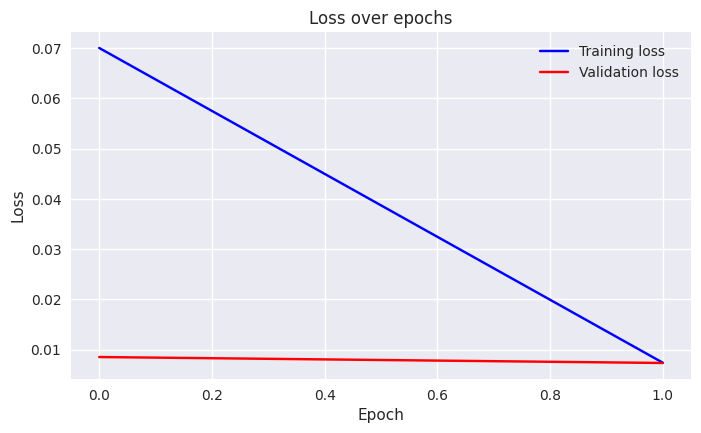

In [31]:
model, optimizer, _ = run_loop(train_loader, validation_loader, criterion, model, optimizer, 2)

In [22]:
single_validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=1, shuffle=False, sampler=Data.SubsetRandomSampler(validation_zero_six_index))

In [23]:
print(next(iter(single_validation_loader))[0].reshape(32,32))
validation_dataset[1]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 2)

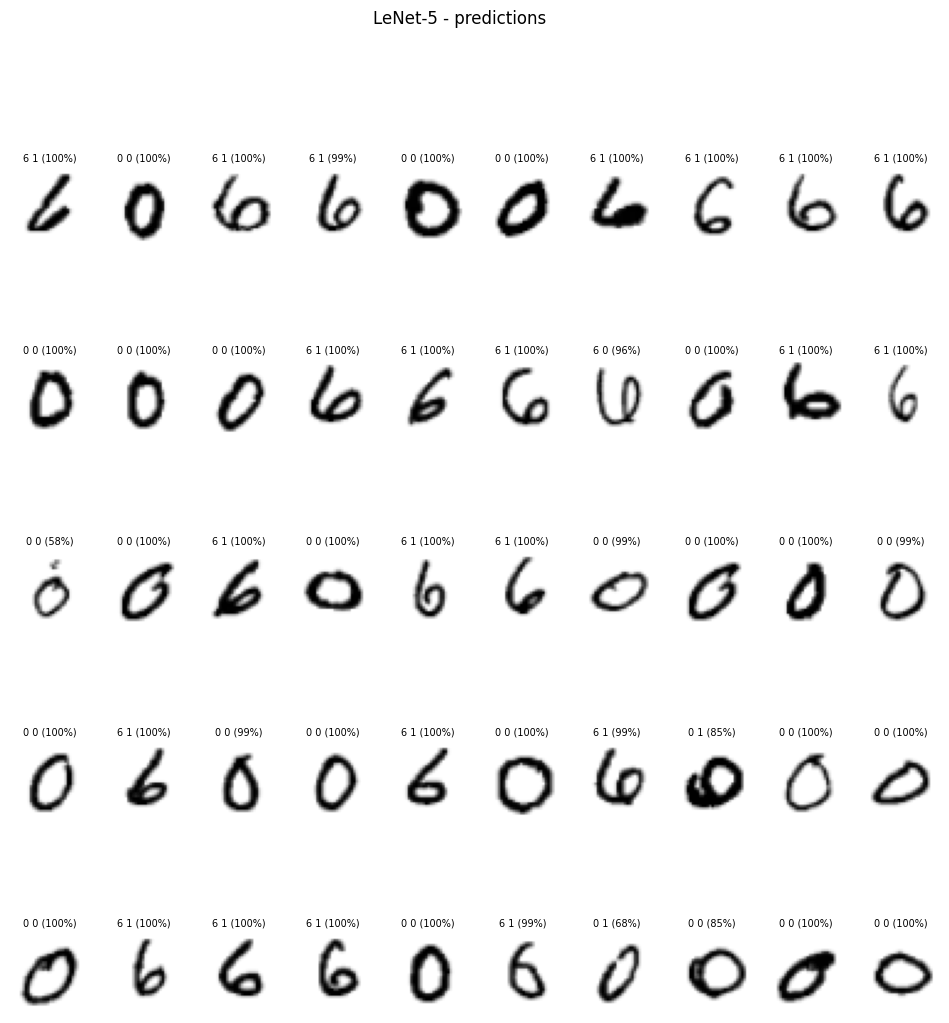

In [24]:
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure(figsize=(12,12))
v_zero_six_index = torch.logical_or(validation_dataset.targets == 0 ,validation_dataset.targets == 6)
filtered_v_data = validation_dataset.data[v_zero_six_index]
filtered_v_targets = validation_dataset.targets[v_zero_six_index]
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    element = next(iter(single_validation_loader))
    plt.imshow(element[0].reshape(32,32), cmap='gray_r')
    
    with torch.no_grad():
        model.eval()
        _, probs = model(element[0] / 255.0)
        
    title = f'{element[1].item()} {torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'
    
    plt.title(title, fontsize=7)
fig.suptitle('LeNet-5 - predictions');